<a href="https://colab.research.google.com/github/ellolo/cthulhu_fine_tuning/blob/main/notebooks/2_lora_qa_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LoRA fine-tuning on QA dataset

This notebook fine-tunes `Llama-3.1-8B-Instruct` and `Llama-3.2-1B-Instruct` on a domain-specific Question Answering (QA) dataset using [Low-Rank Adaptation (LoRA)](https://arxiv.org/abs/2106.09685). The goal is to obtain a fine-tuned model that answers user questions on that domain.

As an example, I use the Chtulhu game as the target domain, and a dataset of about 20K QA pairs derived from the Chtulhu Rulebook as fine-tuning dataset. The process to derive this dataset is described in `1_synt_dataset_generation.ipynb`. The idea is to use the fine-tuned model while playing the Game of Chtulhu, to answer players' questions regarding the rules of the game.

## Stack
- [Hugging Face Transformers](https://huggingface.co/docs/transformers/en/index) to load and quantize the base models, and to perform fine-tuning
- [BitsAndBytes](https://huggingface.co/docs/bitsandbytes/main/en/index) for quantization.
- [Hugging Face Parameter-Efficient Fine-Tuning (PEFT)](https://huggingface.co/docs/peft/en/index) to configure the Lora model.
- [Hugging Face Hub](https://huggingface.co/docs/huggingface_hub/en/index) to store the Lora models checkpoints.

I recommend to use a machine with at least a **A100** Nvidia GPU. Although Lora is designed to save VRAM, a decent GPU is stil needed.

## Details
At a high-level, I do the following (more details are provided in the rest of the notebook):

1. Install dependencies and clone this github repo. I use the repo to read the fine-tuning dataset and also to store performance data of the fine-tuning process.
2. Load the base model (either `Llama-3.1-8B-Instruct` or `Llama-3.2-1B-Instruct`) and quantize it to 4-bits to save VRAM. When quantized, these models are small enough to perform Lora fine-tuning on a A100 GPU.
3. Setup and configure the Lora model. This means that we create low-dimensional Lora adapters on top of specific layers of the base model, and fine-tune the weights of these adapters, leaving the weights of the original base model untouched, thus saving time and VRAM. I add Lora adapeters to all linear layers of the Llama models (both attention and FFN layers) and experiment with a Lora rank of 16 and 64, fix Lora α to 32, and always activate rLora.
4. Load the Chtulhu Rulebook QA pairs dataset. Each example in the dataset is a Question-Answering pair extracted from the Chtulhu Rulebook. More details are provided in the following sections.
5. Fine-tune the Lora model. I track the loss as the main metric across a training and evaluation set split of the dataset. I also track and store VRAM snapshots to monitor the memory usage.

# 1. Install dependencies and clone github repo

The github repo contains the dataset for fine-tuning.

In [ ]:
# install dependecies

%%capture
! pip install -U 'transformers[torch]' peft datasets bitsandbytes #flash-attn


In [ ]:
# get HF token from secrets and login in HF hub, so that we can download models from HF Hub

from huggingface_hub import login
from google.colab import userdata

HF_TOKEN=userdata.get('HF_TOKEN')
if HF_TOKEN:
  login(HF_TOKEN)
else:
  login()

In [ ]:
# Clone github repository.

# Past here the SSH key stored on my personal laptopat: ~/dev/llm_cthulhu_fine_tuning/keys
# This is not safe, but unfortunaly using Colab secrets did not work.
! mkdir -p /root/.ssh
with open("/root/.ssh/id_rsa", mode="w") as fp:
    fp.write("""<YOUR SSH KEY TO THE REPO>""")

# <COPY FROM LOCAL DISK AT: ~/dev/llm_cthulhu_fine_tuning/keys>
! ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
! chmod go-rwx /root/.ssh/id_rsa
! git clone git@github.com:ellolo/cthulhu_fine_tuning.git

# 2. Load quantized pretrained model

I experimented with the following base models: `Llama-3.1-8B-Instruct` and  `Llama-3.2-1B-Instruct`. These models are small enough to be finetuned with LoRA on a A100 GPU.
It could be interesting to experiment also with base models that are not tuned to chat (e.g. `Llama-3.2-1B`) as proposed in [2], with bigger models, and with models other open-sourced models outside Llama family.

The base model is loaded into the GPU with 4-bit BitsAndBytes quantization.  Using quantization saves GPU memory, which allowed me to run LoRA fine-tuning with a 8B model on a single A100 GPU.

- **4-bit vs 8-bit quantization** \\
Two types of quantization are typically used, 8-bit and 4-bit. The latter has slighly lower precision on existing benchmarks, but allows to significantly shrink memory. Using 4-bit instead of 8-bit allowed me to use a bigger model (Llama 8B instead of 3B). This is good, as some empirical evidences [7] show that a 4-bit 8B is more accurate than a a 8-bit 3B model.

- **BitsAndBytes** \\
There are many available approaches to quantize a model, as described in [4, 5]. For PEFT fine-tuning and for working on CUDA/Nvidia, Hugging Face recommends to use BitsAndBytes [9], since it is the most tested for PEFT.

- **Flesh attention** \\
I load the model with flash-attention when the architecture of the GPU allows. Flesh attention should increase memory performance and stability [13, 14, 15].

GPU memory used for base models during my experiments, measured with nvidia-smi:

| Model | Quantization | VRAM (GB) |
|-------|--------------|----------|
| Llama-3.2-1B | none | 5.99 |
| Llama-3.2-1B | 4-bit | 1.60 |
| Llama-3.1-8B | 4-bit | 7.27 |

## References

Fine-tuning in Hugging Face using PEFT:

- [1] https://huggingface.co/docs/transformers/main/en/peft

Best base models for LoRA:
- [2] https://docs.unsloth.ai/get-started/fine-tuning-guide/what-model-should-i-use

Llama 3.2 architecture:
- [3] https://www.analyticsvidhya.com/blog/2024/09/llama-3-2-models/

Quantization quick intro:
- [4] https://huggingface.co/docs/transformers/main/en/quantization/concept_guide
- [5] https://huggingface.co/docs/transformers/en/quantization/overview
- [6] https://huggingface.co/blog/merve/quantization

4-bit vs 8-bit quantization:
- [7] https://www.reddit.com/r/LocalLLaMA/comments/13mxq66/13b_4bit_or_7b_8bits/
- [8] https://medium.com/@shikharstruck/shrinking-elephants-a-funny-guide-to-4-bit-and-8-bit-quantization-for-llms-with-lora-ddf9f1a62070

BitsAndBytes:
- [9] https://huggingface.co/docs/transformers/main/en/quantization/selecting
- [10] https://huggingface.co/blog/4bit-transformers-bitsandbytes
- [11] https://huggingface.co/docs/transformers/en/quantization/bitsandbytes
- [12] https://huggingface.co/docs/transformers/en/main_classes/quantization#transformers.BitsAndBytesConfig

Flesh attention:
- [13] https://huggingface.co/docs/trl/en/sft_trainer#using-flash-attention-and-flash-attention-2
- [14] https://mlabonne.github.io/blog/posts/2024-04-19_Fine_tune_Llama_3_with_ORPO.html
- [15] https://medium.com/data-science-in-your-pocket/what-is-flash-attention-f5dc22522a77




In [ ]:
# Set base model

model_name = "meta-llama/Llama-3.1-8B-Instruct" # "meta-llama/Llama-3.2-1B-Instruct" # "meta-llama/Llama-3.2-1B"

In [ ]:
# Configure BitsAndBytes

import torch
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                     # weights stored in 4 bits (saves memory)
    bnb_4bit_quant_type="nf4",             # format used for storing in 4 bits
    bnb_4bit_use_double_quant=True,        # double quantize (saves memory)
    bnb_4bit_compute_dtype=torch.bfloat16, # perform operations in 16bit instead of 32bit (speed up fine-tuning)
)

In [ ]:
# Load quantized model on GPU

from transformers import AutoModelForCausalLM
from peft import prepare_model_for_kbit_training

SKIP_FLASH_ATTENTION = True # force skipping flash attention

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

mem_start = torch.cuda.memory_allocated(device)

# check if we can use flash-attention
if torch.cuda.get_device_capability()[0] >= 8 and not SKIP_FLASH_ATTENTION:
    print("Using flash-attention")
    attn_implementation = "flash_attention_2"
else:
    print("Using native attention")
    attn_implementation = "eager"

# load model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    attn_implementation=attn_implementation,
).to(device)
model = prepare_model_for_kbit_training(model)

mem_model_load = torch.cuda.memory_allocated(device)
mem_used_model = round((mem_model_load - mem_start) / 1024/1024/1024, 4)
print(f"Using device:{device}")
print(f"Memory used for original model (GB): {mem_used_model}")
print(model)

# 3. Setup LoRA model

I experimented with different Llora hyperparameter setups, largely following existing recommendations from the literature [1, 2, 3]:
- **r**: 16, 64 \\
Literature suggests to keep the Llora rank _r_ between 8 and 128. I tried 16 and 64 to verify the hypothesis that a larger _r_ allows for more capacity and hence increases performance. I did not experiment with _r>64_ as this leads to too much memory usage.
- **α**: 32 \\
Literature suggests to set the scaling factor _α_ to _α=r_ or _α=2*r_. A higher scaling factor amplifies the effect of the fine-tuning, i.e. the Llora. A lower value pushed the model to rely mor eon the original parameters.
- **rLlora**: active \\
rLlora takes the square root of _r_ when merging the Llora adapter, instead of _r_, which brings more stability to the fine-tuning process.

- **layers with Llora**: all linear layers \\
Empirical experiment [1, 3, 4] show that best performance are achieved when applying Llora adapters to all linear layers, including both attention and FFN layers. In the transformer architecture there are: `q_proj, v_proj, k_proj, o_proj` (attention) and `gate_proj, , down_proj, up_proj` (FFN).

- **batch size**: 16, 64
A small batch size allows to save VRAM, but I was able to push to 64 examples on the A100, so to get more stability and faster training time.


## References

Llora intro:
- [1] https://arxiv.org/abs/2106.09685
- [2] https://medium.com/@kednaik/llm-fine-tuning-with-lora-8e06f2227183

Hyperparameters setting for Llora:
- [3] https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide
- [4] https://www.reddit.com/r/LocalLLaMA/comments/15sgg4m/what_modules_should_i_target_when_training_using/
- [5] https://www.anyscale.com/blog/fine-tuning-llms-lora-or-full-parameter-an-in-depth-analysis-with-llama-2



In [ ]:
# Set Llora hyperparameters

from peft import LoraConfig, get_peft_model

def get_linear_layers(model, exclude_lm_head = True):
    """
    Returns the short sematic name of all layers that are linear,
    (excluding the final head layer if needed).

    Args:
        model: HF model to get linear layers from.
        exclude_lm_head (boolean, optional): True if lm_head layer must be included
    Returns:
        list: List of linear layers of the model.
    """
    linear_layers = set()
    for name, module in model.named_modules():
      module_type = str(type(module))
      if "Linear" in module_type:
        linear_layers.add(name.split(".")[-1])
    if exclude_lm_head and 'lm_head' in linear_layers:
      linear_layers.remove("lm_head")
    return list(linear_layers)

print(f"Linear layers: {get_linear_layers(model)}")

LORA_R = 64 #16
LORA_ALPHA = 32

lora_config = LoraConfig(
    r=LORA_R,                                 # rank (dim) of the adapters A and B. Higher value means more parameters to train (more expressivity but also more mem). Increasing does not bring substantial increase in performance.
    lora_alpha=LORA_ALPHA,                    # magnitude of adapter in changing the orginal params (W' = W + a*(A*B)). Usually a=2*r. Typicall set between 4 and 64. High a leans more to the adapter, low a leans more on original weights. Should be bigger for smaller models.
    target_modules= get_linear_layers(model), # to which layers to apply lora adapters. This is the param that influences performance the most. According to QLoRA paper should use adapters to all linear layers to match full finetuning accuracy
    lora_dropout=0.0,                         # setting to 0 allows faster training, but risks some overfitting
    bias="none",
    use_rslora=True,                          # stabilizes adapters
    task_type="CAUSAL_LM",
)

Linear layers: ['q_proj', 'v_proj', 'k_proj', 'gate_proj', 'o_proj', 'down_proj', 'up_proj']


In [ ]:
# Add LoRA adapters to the selected layers of the base model's architecture.

from peft import PeftModelForCausalLM

model: PeftModelForCausalLM = get_peft_model(model, lora_config)

mem_lora_model_load = torch.cuda.memory_allocated(device)
mem_used_lora_model = round((mem_lora_model_load - mem_model_load) / 1024/1024/1024, 4)
print(f"Memory used for original model (GB): {mem_used_model}")
print(f"Memory used for LoRA model (GB): {mem_used_lora_model}")
print(model)
print("*"*20)
model.print_trainable_parameters()

# 4. Prepare QA dataset

I fine-tune the LLM with a dataset of  11,930 Question-Ansering (QA) pairs extracted from the Chtuhlu Rulebook using the [Meta Synthetic Data Kit (MSDK)](https://github.com/meta-llama/synthetic-data-kit/tree/main/synthetic_data_kit). The process to generate the dataset is described in `1_synt_dataset_generation.ipynb`.

In practice, each QA pair is modeled as a chat session, where the user asks the question and the LLM answers it. This should teach the LLM to answer questions about the Chtuhlu game.  Here is an example of a QA pair from the dataset, which follows the typical [1, 2] json format:

```
{"messages": [
  { "role": "system",
    "content": "You are a helpful AI assistant."
  },
  { "role": "user",
    "content": "What happens when establishing a contact with a non-player character?"
  },
  { "role": "assistant",
    "content": "A successful roll means the non-player character has heard of the investigator by reputation or has previously met the contact."
  }
  ]}
```

Specifically, I do the following:

1. Load the Tokenizer of the base model, load the dataset, and format each QA pair into the  model's internal chat template [1]. We ensure that:
  - The base model is an **Instruct model**. \\
This means that the base model is already pretrained to interactively chat with the user. This makes our Llora fine-tuning easier, as we only need to teach the model to respond to domain-specific questions, and not also to learn to chat.
  - The Tokenizer class of the model implements the `apply_chat_template()` method, which converts the ChatML json format into the LLM's chat template that was used for pretraining, so that our dataset is consistent to the original pretrained data. If you are not using a model that has a chat template, you need to add new special tokens to the tokenizer's vocabulary [3], which model the chat's roles and contenxt (e.g. Llama 3 uses the following tokens: `<|begin_of_text|>`, `<|enf_of_text|>`, `<|eot_id|>`).

2. Tokenize the dataset [4, 5, 6] and remove pairs that exceed `MAX_SEQ_LENGTH` in order to save memory at fine-tuning time.

3. Initialize the Data Collator that will generate batches during fine-tuning. \\
I use the `DataCollatorForLanguageModeling` which performs the following for each batch (see [7] for a complete guide):
 - **Padding**: finds the example in the batch with the longest 'input_ids'  token sequence _n_. Pads the 'input_ids' token sequence of the other examples in the batch up to _n_, using the tokenizer's pad token. This results in all token sequences in the batch to have the same length.
 - **Labels**: create a new 'label sequence' for each example in the batch. This is the field used by the Trainer to compute the loss. The label sequence is created as follows. First, it copies the token ids from the 'input_ids' sequence into the label sequence. Then, it replaces pad token ids with -100 so that pad tokens are not used for loss computation. \\
Note that the label for token $u_i$ should be token $u_i+1$ since we want to predict the _next_ token $u_i+1$ from the context $u_0...u_i$. Therefore we we would expect the Data Collator to not simply 'copy' the input_ids into the label sequence, but to shift the label of one position. In Hugging Face this shifting is actualy done by the trainer itself [8], therefore just copying is ok.



### Note about Pad token in Llama.

`DataCollatorForLanguageModeling` requires the Tokenizer to have a pad token, or it fails. Since Llama does not have a pad token, I set it manually to one of the unused 'reserved tokens' (see file tokenizer_config.json in Hugging Face). Specificially I used the aptly named `<|finetune_right_pad_id|>` [10].
I could have alternaitely used the `eos_token` or a brand new token, but these have the following disadvantages:
-  eos_token: this would result in the collator to 'mask' the eos_token (i.e.
set all the occurrences of eos_token, also those that actually mean 'end of sentence') to -100. This may result in the model never to emit eos_token, end therefore endlessly generate [11, 12].
- new token: this would change the token vocabulary size. We would therefore need to resize the embedding layers, which is inconvenient and may not work with quantized models [13, 14].


## References

Chat templates and ChatML
- [1] https://huggingface.co/docs/transformers/en/chat_templating
- [2] https://github.com/openai/openai-python/blob/release-v0.28.0/chatml.md
- [3] https://huggingface.co/docs/trl/en_sft_trainer#add-special-tokens-for-chat-format

Tokenization in Hugging Face:
- [4] https://huggingface.co/learn/llm-course/chapter2/4?fw=pt
- [5] https://huggingface.co/learn/llm-course/chapter3/2?fw=pt
- [6] https://huggingface.co/learn/llm-course/chapter2/5?fw=pt#attention-masks

Data Collators:
- [7] https://towardsdatascience.com/data-collators-in-huggingface-a0c76db798d2/
- [8] https://huggingface.co/learn/llm-course/en/chapter7/6#initializing-a-new-model
- [9] https://discuss.huggingface.co/t/how-labelled-data-is-processed-transformers-trainer/80644/6

Pad token in Llama:
- [10] http://github.com/unslothai/unsloth/issues/416
- [11] https://github.com/huggingface/transformers/issues/25773
- [12] https://github.com/huggingface/transformers/issues/22794
- [13] https://medium.com/@coldstart_coder/adding-custom-tokens-to-huggingface-models-1981f114efc1
- [14] https://www.youtube.com/watch?v=MB0ZJ5Y-07s           


In [ ]:
# Load tokenizer and ensure we use an Instruct model

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)
try:
  tokenizer.apply_chat_template([{"role":"system", "content":"try"}])
except ValueError:
  raise ValueError("You are using a model that is not an 'instruct' (i.e. chat) model. Please:\n 1. replace function apply_chat_template() with your own function to format examples into chatML \n 2. specify chatml special tokens by hand as described in: https://huggingface.co/docs/trl/en/sft_trainer#add-special-tokens-for-chat-format")


In [ ]:
# Loads the dataset from the Cthulhu guidebook's QA pairs.

import glob
import json
from pathlib import Path
from datasets import Dataset

%cd /content/cthulhu_fine_tuning

def generate_examples(dir: str, tokenizer, last_index) -> str:
  """
  Generator function to load QA pairs from JSON files and format them into ChatML.

  Args:
      dir (str): The directory containing the JSON files.
      tokenizer: The tokenizer with an `apply_chat_template` method.
      last_index: The index of the last file to include in the dataset.

  Yields:
      dict: A dictionary containing 'file_index' and 'chatml' for each example,
      where 'file_index' is the index of the file the example is extracted from,
      and 'chatml' is the actual conversation in the chatML format of the specific
      LLM model.
  """
  fnames = glob.glob(f"{dir}/*.json")
  for fname in fnames:
    file_index = int(Path(fname).name.split("_")[1])
    with open(fname) as f:
      if last_index and file_index > last_index:
        print(f"Skipping file: {fname}")
        continue
      for line in f:
        messages = json.loads(line)["messages"]
        chatml = tokenizer.apply_chat_template( # will fail if the model is not an instruct model
            messages,
            tokenize=False,
            add_generation_prompt=False
        )
        yield {"file_index":file_index, "chatml": chatml}


#DATASET_LAST_FILE_INDEX=159
DATASET_LAST_FILE_INDEX=None
dataset_path = "data/final_cleaned"

dataset = Dataset.from_generator(
    generate_examples,
    gen_kwargs={
        "dir": dataset_path,
        "tokenizer": tokenizer,
        "last_index": DATASET_LAST_FILE_INDEX
        },
    split="train"
    )

# print first QA pair of the training dataset in internal ChatML format
print(dataset[0])

## sort according to original document
#dataset = dataset.sort("file_index")

In [ ]:
# Tokenize dataset, remove long examples, split into training/testing.

from itertools import compress
from transformers import AutoTokenizer, AutoModelForCausalLM


def get_model_max_seq_length(model: AutoModelForCausalLM):
  """
  Determines the maximum sequence length supported by the model.

  Args:
      model (AutoModelForCausalLM): The Hugging Face causal language model.

  Returns:
      int: The maximum sequence length. Defaults to 1024 if not found in model config.
  """
  max_context = None
  for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
      max_context = getattr(model.config, length_setting, None)
      if max_context:
          print(f"Found model max context: {max_context}")
          break
  if not max_context:
      max_context = 1024
      print(f"Using default max context: {max_context}")
  return max_context


def tokenize(dataset, tokenizer: AutoTokenizer):
  """
  Tokenizes the dataset using the provided tokenizer.

  Args:
      dataset: The dataset to tokenize.
      tokenizer (AutoTokenizer): The tokenizer to use.

  Returns:
      dict: A dictionary containing the tokenized data.
  """
  return tokenizer(
      dataset["chatml"],
      padding=False, # padding will be done by the DataCollector
      truncation=True,
      )


# max length of the context that we allow (keeps mem in check)
MAX_SEQ_LENGTH = 256

# tokenize
dataset_tokenized = dataset.map(
    tokenize,
    remove_columns=["file_index", "chatml"],
    batched=True,
    fn_kwargs={"tokenizer": tokenizer},
  )

# remove examples that are too long
length_bf = len(dataset_tokenized)
max_seq_length = min(MAX_SEQ_LENGTH, get_model_max_seq_length(model))
dataset_tokenized = dataset_tokenized.filter(lambda x: len(x["input_ids"]) <= max_seq_length)

# split into train and eval sets
dataset_tokenized = dataset_tokenized.train_test_split(test_size=0.05, shuffle=True, seed=42)

# stats
print("*"*40)
print(f"Dataset size before truncating at {max_seq_length}: {length_bf}")
print(f"Dataset size after truncating at {max_seq_length}: {len(dataset_tokenized)}")
print(f"Examples in training set: {len(dataset_tokenized['train'])}")
print(f"Examples in test set: {len(dataset_tokenized['test'])}")
print("*"*40)

print(f"\n{dataset_tokenized}")
print("*"*20)
print("tokenized example:")
print(dataset_tokenized["train"][0])
print("*"*20)
print("decoded tokenized example:")
print(tokenizer.decode(dataset_tokenized["train"][0]["input_ids"]))
print("*"*20)
print("Decoded tokenized example (only tokens that are not masked):")
print(tokenizer.decode(list(compress(dataset_tokenized["train"][0]["input_ids"], dataset_tokenized["train"][0]["attention_mask"]))))

max context length in dataset: 217
min context length in dataset: 49


<BarContainer object of 84 artists>

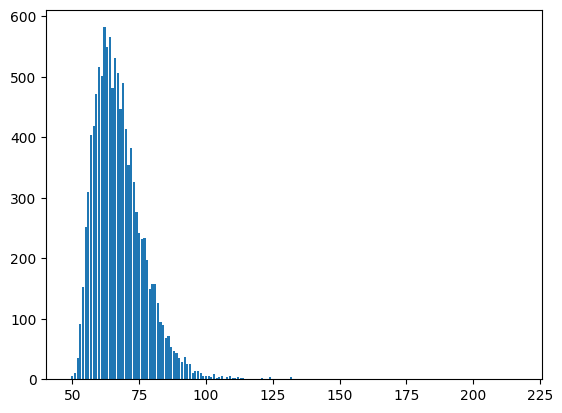

In [ ]:
# plot distribution of context length across the dataset

from collections import defaultdict
from matplotlib import pyplot as plt

context_lengths = defaultdict(int)
for example in dataset_tokenized["train"]:
  context_lengths[len(example["input_ids"])] += 1

print(f"max context length in dataset: {max(context_lengths.keys())}")
print(f"min context length in dataset: {min(context_lengths.keys())}")
display(plt.bar(context_lengths.keys(), context_lengths.values()))

In [ ]:
# set pad token for Llama tokenizer

tokenizer.add_special_tokens({"pad_token": "<|finetune_right_pad_id|>"})
model.config.pad_token_id = tokenizer.pad_token_id
tokenizer.padding_side = 'right'

print("*"*40)
print(f"Tokenizer vocab size before adding pad token: {len(tokenizer)}")
print(f"Tokenizer vocab size after adding pad token: {len(tokenizer)}")
print('Tokenizer pad token:', tokenizer.pad_token)
print('Tokenizer pad token id:', tokenizer.pad_token_id)
print('Model pad token id:', model.config.pad_token_id)
print("*"*40)


# inizialize data collator
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

****************************************
Tokenizer vocab size before adding pad token: 128256
Tokenizer vocab size after adding pad token: 128256
Tokenizer pad token: <|finetune_right_pad_id|>
Tokenizer pad token id: 128004
Model pad token id: 128004
****************************************


In [ ]:
# let's check that the data collator produces output as we expect

import torch

dataloader = torch.utils.data.DataLoader(
    dataset_tokenized["train"],
    collate_fn=data_collator,
    batch_size=2
    )

def occurrence_token_id(tensor, token_id):
  mask = token_id == tensor
  return mask.sum().item()

i = 0
for batch in dataloader:
      print()
      print(f"Sequences length: {len(batch['input_ids'][0])}")
      print(f"Padding tokens in sequence 1: {occurrence_token_id(batch['input_ids'][0], tokenizer.pad_token_id)}")
      print(f"Padding tokens in sequence 2: {occurrence_token_id(batch['input_ids'][1], tokenizer.pad_token_id)}")
      print(f"Sequence 1 decoded:\n {tokenizer.decode(batch['input_ids'][0])}")
      print(f"\nSequence 2 decoded:\n {tokenizer.decode(batch['input_ids'][1])}")
      print(f"Actual input to Trainer:")
      print(batch)
      print("*"*50)
      if i == 2:
        break
      i += 1

# 5. Execute fine-tuning

Now that the dataset is ready, that the base model is loaded and that the Llora hyper-parameters are set, we can execute the actual fine-tuning. I did the following:

1. If the fine-tuning process was already started in a previous session, download the corresponding checkpoints from the Hugging Face Hub to the local file system.

2. Set fine-tuning parameters:.
  -  **Learning rate** [1, 2, 3]: I experimented with 1e-4, and reduced to 3e-5 if training was unstable. Typically, when increasing LoRA α, the learning rate should decrease accordingly. \\
    I used a simple Linear Scheduler [4], which warms up the learning rate until `warmup_ratio` steps, then linearly decreases it.
  - **Epochs** [5]: I set this to 3 and checked covergence during the learning process.
  - **Batch size** [6]: I set the batch size as big as possible based on VRAM availability. I typically used 16, but pushed to 64 when memory allowed it.

3. Execute fine-tuning.

4. Save the following:
  - to Hugging Face Hub => best model and last checkpoint model. I use my personal HF namespace `mpenna77`
  - to Github => PyTorch memory profiling files [10]


## References

Learning rate for Llora:
- [1] https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide#learning-rate
- [2] https://www.determined.ai/blog/lora-parameters
- [3] https://www.anyscale.com/blog/fine-tuning-llms-lora-or-full-parameter-an-in-depth-analysis-with-llama-2?_gl=1*1xhtjl9*_gcl_au*ODk3ODg5MjE3LjE3NDc5MDcwODY.#sensitivity-of-lora-to-learning-rate
- [4] https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.get_linear_schedule_with_warmup

Epochs for Llora:
- [5] https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide#epochs

Batch size for Llora:
- [6] https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide#effective-batch-size

Use PEFT and Trainer in Hugging Face:
- [7] https://huggingface.co/docs/peft/quicktour
- [8] https://huggingface.co/docs/transformers/v4.52.2/en/trainer
- [9] https://huggingface.co/learn/llm-course/chapter3/2?fw=pt

Memory profiling in PyTorch:
- [10] https://zdevito.github.io/2022/12/09/memory-traces.html

In [ ]:
# Get model checkpoints from Hugging Face Hub to local file system.
# This is only needed to resume fine-tuning from a pre-existing checkpoint

#from huggingface_hub import HfApi

#%cd /content/cthulhu_fine_tuning/


#namespace="mpenna77"

#api = HfApi(token=userdata.get('HF_TOKEN_WRITE')) # read HF token from Colab secrets
#api.snapshot_download(
#    "mpenna77/Llama-3.1-8B-Instruct-lr0.0001-b16-r64-a32-lora-cthulhu",
#    local_dir="../Llama-3.1-8B-Instruct-lr0.0001-b16-r64-a32-lora-cthulhu")


In [ ]:
# Execute fine-tuning

import time
import torch
from pathlib import Path
from transformers import TrainingArguments, Trainer, TrainerCallback, DataCollatorWithPadding

%cd /content/cthulhu_fine_tuning

LR = 1e-4
#BATCH_SIZE = 64
BATCH_SIZE = 16


run_name = f"{model_name.split('/')[-1]}-lr{LR}-b{BATCH_SIZE}-r{LORA_R}-a{LORA_ALPHA}-lora-cthulhu"
if DATASET_LAST_FILE_INDEX:
  run_name += f"-cut{DATASET_LAST_FILE_INDEX}"
out_dir = f"fine-tuning/models/{run_name}"
print(run_name)

Path(out_dir).mkdir(exist_ok=True, parents=True)

training_args = TrainingArguments(
    output_dir=out_dir,
    learning_rate=LR,                        # start with 1e-4 and reduce to 3e-5 if training is unstable. If increasing LoRA apha, learning rate should decrease accordingly.
    gradient_accumulation_steps = 1,         # after how many steps (batches) to sum up the gradient and then update params
    lr_scheduler_type = "linear",            # learning rate is warmed up linearly until warmup_ratio steps, then linearly decreases
    warmup_ratio = 0.05,                     # first x% of training steps will be used to slowly ramp-up learning rate (default is 0.1). Makes training more stable.
    weight_decay=0.3,                        # keep between 1.0 and 0.3
    per_device_train_batch_size=BATCH_SIZE,  # depends on VRAM availability
    per_device_eval_batch_size=BATCH_SIZE,   # depends on VRAM availability
    num_train_epochs=3,                      # 3 should be sufficient. More could overfit and decrease creativity.
    eval_strategy="steps",                   # set to "epoch" if running evaluation every epoch, or "step" if at every batch
    save_strategy="steps",                   # set to "epoch" if storing checkpoints every epoch, or "step" if at every batch
    save_steps=250,
    eval_steps=250,
    logging_steps=25,
    load_best_model_at_end=True,     # returns the best checkpointed model at the end of training, determined as the checkpoint with smallest loss on eval dataset
    report_to="none",                # Disable 'Weights and Biases' reporting
    label_names=["labels"],          # see: https://github.com/unslothai/unsloth/issues/1788
    #max_steps = 20,
)

time_start_training = time.perf_counter()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    #compute_metrics=compute_metrics,
)

# start capturing VRAM snapshots
torch.cuda.memory._record_memory_history(max_entries=100000)

# fine-tune from scratch
results = trainer.train()
## fine-tune resuming from a pre-existing checkpoint
#results = trainer.train(resume_from_checkpoint="/content/Llama-3.1-8B-Instruct-lr0.0001-b16-r64-a32-lora-cthulhu/checkpoint-1000")

# end capturing VRAM snapshots
torch.cuda.memory._record_memory_history(max_entries=100000)

time_end_training = time.perf_counter()


In [ ]:
# Saving model checkpoints to Hugging Face Hub
#
# TODO: This could be done easier by just setting the option in the Trainer.
#       See Notebook 3_lora_cont_pretraining.ipynb for how to do this.

from huggingface_hub import HfApi

%cd /content/cthulhu_fine_tuning/


def upload_to_hub(api, hub_repo_id, model_local_path, peft_checkpoint):
  """
  Uploads a model checkpoint to the Hugging Face Hub.

  Args:
      api (HfApi): The Hugging Face API object.
      hub_repo_id (str): The ID of the repository on the Hugging Face Hub.
      model_local_path (str): The local path to the model.
      peft_checkpoint (str): The name of the PEFT checkpoint to upload.
  """
  api.create_repo(repo_id=f"{namespace}/{hub_repo_id}", private=True, exist_ok=True)
  api.upload_folder(
      folder_path=f"{model_local_path}/{peft_checkpoint}",
      repo_id=f"{namespace}/{hub_repo_id}",
      path_in_repo=peft_checkpoint,
      repo_type="model",
  )

namespace="mpenna77"
out_dir = f"fine-tuning/models/{run_name}"

api = HfApi(token=userdata.get('HF_TOKEN_WRITE')) # read HF token from Colab secrets

#upload best model
upload_to_hub(api, run_name, out_dir, "best-model")

#upload last model
upload_to_hub(api, run_name, out_dir, f"checkpoint-{trainer.state.max_steps}")

## upload other checkpoints
#upload_to_hub(api, run_name, out_dir, f"checkpoint-250")
#upload_to_hub(api, run_name, out_dir, f"checkpoint-500")
#upload_to_hub(api, run_name, out_dir, f"checkpoint-750")
#upload_to_hub(api, run_name, out_dir, f"checkpoint-1000")
#upload_to_hub(api, run_name, out_dir, f"checkpoint-1250")
#upload_to_hub(api, run_name, out_dir, f"checkpoint-1500")
#upload_to_hub(api, run_name, out_dir, f"checkpoint-1750")
#upload_to_hub(api, run_name, out_dir, f"checkpoint-2000")

In [ ]:
print(run_name)

Llama-3.1-8B-Instruct-lr0.0001-b16-r64-a32-lora-cthulhu


In [ ]:
# Saving VRAM snapshots to Github

%cd /content/cthulhu_fine_tuning

profiling_dir = f"fine-tuning/profiling/{run_name}"
profiling_file = f"{profiling_dir}/profile.pkl"
profiling_viz_file = f"{profiling_dir}/trace.html"

# saving memory profile file to local file system
Path(profiling_file).parent.mkdir(exist_ok=True, parents=True)
torch.cuda.memory._dump_snapshot(profiling_file)
torch.cuda.memory._record_memory_history(enabled=None)

# generating memory profile visualuzation files in local file system
! wget https://raw.githubusercontent.com/pytorch/pytorch/master/torch/cuda/_memory_viz.py
! python _memory_viz.py trace_plot {profiling_file} -o {profiling_viz_file}


# do the following the first time to push safetensors to github lfs
##! git lfs install
##! git lfs track "*safetensors"
##! git add .gitattributes

# pushing profiling files to github
! git config --global user.email "marco.pennacchiotti@gmail.com"
! git add {profiling_dir}
! git commit -m "added new profiling files"
! git push origin main

In [ ]:
# Print VRAM memory usage

import torch

mem_training = torch.cuda.max_memory_allocated(device)
mem_used_training = round((mem_training - mem_lora_model_load) / 1024/1024/1024, 4)


print(f"training time: {(time_end_training - time_start_training):.1f} s")
print(f"Memory used for original model (GB): {mem_used_model}")
print(f"Memory used for LoRA model (GB): {mem_used_lora_model}")
print(f"Memory used for training (GB): {mem_used_training}")


training time: 2490.6 s
Memory used for original model (GB): 7.2716
Memory used for LoRA model (GB): 0.1562
Memory used for training (GB): 5.2251


## Sample inference

- Load best fine-tuned model checkpoint
- Perform inference on sample user question

In [ ]:
# TEST BEST MODEL
#
# Let's load the best model and do some generation.

from transformers import TextStreamer

tmp_model = AutoModelForCausalLM.from_pretrained(f"{out_dir}/best-model").to(device)

messages = [
    {"role": "user", "content": "How does a player fight an enemy?"},
    #{"role": "user", "content": "Who invented Cthulhu?"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to(device)

print("*"*20)
print("Tokenized input:")
print(tokenizer.decode(inputs[0]).strip())
print("*"*20)
print("\nAnswer:")

_ = tmp_model.generate(
    input_ids=inputs,
    pad_token_id=tokenizer.pad_token_id,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
    max_new_tokens = 256,
    temperature = 0.1
    )

# Utils to check GPU status

In [ ]:
!  nvidia-smi

In [ ]:
! fuser -v /dev/nvidia*

In [ ]:
! sudo kill -9 9203

# Old code (deprecated)



In [ ]:
# SAVING TO GITHUB: BEST MODEL, LAST MODEL, PROFILING FILES

%cd /content/cthulhu_fine_tuning/

print(f"Best model at step: {trainer.state.best_global_step}")
print(f"Best model checkpoint: {trainer.state.best_model_checkpoint}")
print(f"Metric at best step (on eval set): {trainer.state.best_metric}")

best_model_dir = f"{out_dir}/best-model"
best_model_state_file = f"{out_dir}/best-model-trainer_state.json"
last_model_dir = f"{out_dir}/checkpoint-{trainer.state.max_steps}"

trainer.save_model(best_model_dir)
trainer.state.save_to_json(best_model_state_file)

#! git lfs install
#! git lfs track "*safetensors"
#! git add .gitattributes
! git config --global user.email "marco.pennacchiotti@gmail.com"
! git add {best_model_dir}
! git add {best_model_state_file}
! git add {last_model_dir}/*json
! git add {last_model_dir}/*md
! git add {last_model_dir}/*safetensors
! git add {last_model_dir}/*jinja
! git add {profiling_dir}
! git commit -m "added new model"
! git push origin main

In [ ]:
from huggingface_hub import HfApi

def upload_to_hub(api, hub_repo_id, model_local_path, checkpoint):
  api.create_repo(repo_id=f"mpenna77/{hub_repo_id}", private=True, exist_ok=True)
  api.upload_folder(
      folder_path=f"{model_local_path}/{checkpoint}",
      repo_id=f"mpenna77/{hub_repo_id}",
      path_in_repo=checkpoint,
      repo_type="model",
  )

api = HfApi(token=userdata.get('HF_TOKEN_WRITE'))

upload_to_hub(api, run_name, out_dir, checkpoint)

#hub_model_name_last = f"{run_name}-checkpoint-{trainer.state.max_steps}"
#model_dir_last = f"{out_dir}/checkpoint-{trainer.state.max_steps}"
#upload_to_hub(api, hub_model_name_last, model_dir_last)

#hub_model_name_best = f"{run_name}-best-model"
#model_dir_best = f"{out_dir}/best-model"
#upload_to_hub(api, hub_model_name_best, model_dir_best)

## Torch Cuda Profiler

This was code used to print a profile of the memory but unfortunately it breaks with LoRa.

In [ ]:
# TRAINING WITH PROFILER
# Profiling with torch.profiler:
# - https://huggingface.co/docs/accelerate/usage_guides/profiler
# - https://zdevito.github.io/2022/12/09/memory-traces.html
# - https://discuss.pytorch.org/t/is-there-a-pytorch-profiler-integration-with-huggingface-trainer/160497/2


# class to log memory state at each training step
class ProfCallback(TrainerCallback):
    def __init__(self, prof):
        self.prof = prof

    # will execute at every step (i.e. batch) of training
    def on_step_end(self, args, state, control, **kwargs):
        self.prof.step()

results = None
with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU,
                                        torch.profiler.ProfilerActivity.CUDA],
                            on_trace_ready=torch.profiler.tensorboard_trace_handler('tmp-hf-training-trainer'),
                            schedule=torch.profiler.schedule(skip_first=1, wait=5, warmup=1, active=3, repeat=2),
                            profile_memory=True,
                            with_stack=True,
                            record_shapes=True) as prof:

    trainer.add_callback(ProfCallback(prof=prof))
    results = trainer.train()


# SAVING FILE

profiling_file = f"fine-tuning/profiling/{run_name}/output.html"
Path(profiling_file).parent.mkdir(exist_ok=True, parents=True)
with open(profiling_file, "w") as f:
  f.write(torch.cuda._memory_viz.profile_plot(prof))

## Basic tokenizer and model usage

This code was used to experiment with the transformer library

In [ ]:
# loading model and its tokenizer
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM

model_name = "meta-llama/Llama-3.2-1B"

model = AutoModel.from_pretrained(model_name)
model_causal = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
input_ids = tokenizer("Today it is a beatiful day in", return_tensors="pt")
print(input_ids)

In [ ]:
model_output = model.forward(**input_ids)
model_output[0].shape

In [ ]:
model_causal_output = model_causal.forward(**input_ids)
model_causal_output[0].shape

In [ ]:
model_causal_generated = model_causal.generate(**input_ids, max_new_tokens=50)

In [ ]:
model_causal_generated.shape

In [ ]:
model_causal_generated

In [ ]:
tokenizer.decode(model_causal_generated[0])

## DataCollator and padding

this code shows how the DataCollator (i.e. the processor that provides batches to the Trainer during training or fine-tuning), not only creates batches of a given size from the dataset, but also ensures that each example in the batch has the same sequence length by padding with the pad token of the tokenizer.
See: https://towardsdatascience.com/data-collators-in-huggingface-a0c76db798d2/

Note also the different behaviour of `DataCollatorForLanguageModeling` and `DataCollatorForSeq2Seq`.

The `DataCollatorForLanguageModeling` automatically creates the **Label** field to pass to the Trainer.
'Labels' are used by the loss function to compute the loss.\
Specifically, at training time, in the forward pass, for a specific token in the sequence (say in position K), the Trainer gets a prob distribution over the token vocabulary. It then takes the token with highest probability (say 12344) and compares it with the ground truth token at position K in the Label field (say the token id is 23433) and computes the loss accordingly.\
Note that when a Label has -100 as a value, that token position wont be considered in computing the loss. This is indeed the case when doing padding: when a token is a padding token, `DataCollatorForLanguageModeling` set its label to -100 and its attention mask to 0, because we do not want to consider pad tokens in computing the loss, as they are not meaningful for the task. See the example below to see this.

Summarizing `DataCollatorForLanguageModeling` does the following:
- Gets all examples in the batch
- Computes the longest token sequence of all examples. Pads all other example to the right up to the longest token sequence, using the padding token. Now all examples have the same token sequence length, which can be used in the NN.
- Creates automatically a `Label` field, which is actually a copy of the tokens (i.e. input_ids). However, it replaces padding tokens with -100, so that this is ignored when computing the loss function.


In [ ]:
from transformers import DataCollatorForLanguageModeling
from transformers import AutoTokenizer
import torch

def tokenize(dataset, tokenizer: AutoTokenizer):
  """
  Tokenizes the dataset. If the number of tokens of an example exceed the max
  context length, the example will be truncated.
  """
  return tokenizer(
      dataset["chatml"],
      truncation=True,
      padding=False,
      )


tmp_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


tmp_dataset_tokenized = dataset.map(
    tokenize,
    remove_columns=["file_index", "chatml"],
    batched=True,
    fn_kwargs={"tokenizer": tmp_tokenizer},
  )

collate_fn = DataCollatorForLanguageModeling(tokenizer=tmp_tokenizer, mlm=False)
dataloader = torch.utils.data.DataLoader(tmp_dataset_tokenized["train"], collate_fn=collate_fn, batch_size=2)

i = 0
for batch in dataloader:
      print(f"Tensors length: {len(batch['input_ids'][0])}")
      print(f"Non zero elements in sentence 1: {len(batch['input_ids'][0].nonzero())}")
      print(f"Non zero elements in sentence 2: {len(batch['input_ids'][1].nonzero())}")
      print(f"Zero elements in sentence 1: {len(batch['input_ids'][0]) - len(batch['input_ids'][0].nonzero())}")
      print(f"Zero elements in sentence 2: {len(batch['input_ids'][1]) - len(batch['input_ids'][1].nonzero())}")
      print(batch)
      if i == 2:
        break
      i += 1

Let's now see what `DataCollatorForSeq2Seq` does.
It does as the other DataCollator, but does not create the Label field.

In [ ]:
from transformers import DataCollatorForSeq2Seq

collate_fn = DataCollatorForSeq2Seq(tokenizer=tmp_tokenizer)
dataloader = torch.utils.data.DataLoader(tmp_dataset_tokenized["train"], collate_fn=collate_fn, batch_size=2)

i = 0
for batch in dataloader:
      print(f"Tensors length: {len(batch['input_ids'][0])}")
      print(f"Non zero elements in sentence 1: {len(batch['input_ids'][0].nonzero())}")
      print(f"Non zero elements in sentence 2: {len(batch['input_ids'][1].nonzero())}")
      print(f"Zero elements in sentence 1: {len(batch['input_ids'][0]) - len(batch['input_ids'][0].nonzero())}")
      print(f"Zero elements in sentence 2: {len(batch['input_ids'][1]) - len(batch['input_ids'][1].nonzero())}")
      print(batch)
      if i == 2:
        break
      i += 1

This example is taken from from the "in-context" QA tutorial from HF (https://huggingface.co/docs/transformers/tasks/question_answering, https://huggingface.co/learn/llm-course/chapter7/7). This is not a generative task, but a classification task: the model has to identify in which position of the text context that is given, is the answer to a specific question.\
Each example containts a context text, a question and the correct answer, which is contained in the context. The task for the LLM is to learn to answer the question by finding the answer in the context and generate as is, in its answer.
Fundamentally one passes as trainable tokens (i.e. not masked) the follwoing "[CLS]question [SEP] context [SEP]". These "trainable tokens" are those that will be passed to the QA loss function to compute the correct answer.


In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset

squad = load_dataset("squad", split="train[:5000]")
squad = squad.train_test_split(test_size=0.2)

tmp2_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tmp2_tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

tokenized_squad = squad.map(preprocess_function, batched=True, remove_columns=squad["train"].column_names)

In [ ]:
from itertools import compress

example = squad["train"][0]
tokenized_example = tokenized_squad["train"][0]

print("Example:")
print(example)
print("*"*20)
print("Tokenized example:")
print(tokenized_example)
print("*"*20)
print("Decoded tokenized example:")
print(tmp2_tokenizer.decode(tokenized_example["input_ids"]))
print("*"*20)
print("Decoded tokenized example (only tokens between start_positions and end_positions):")
print(tmp2_tokenizer.decode(tokenized_example["input_ids"][tokenized_example["start_positions"]:tokenized_example["end_positions"]]))
print("*"*20)
print("Decoded tokenized example (only tokens that are not masked):")
print(tmp2_tokenizer.decode(list(compress(tokenized_example["input_ids"], tokenized_example["attention_mask"]))))


## Chat templates



Few shot example using Llama 3.1 chat model

In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM

model_chat = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B-Instruct", device_map="auto")
tokenizer_chat = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

device = model_chat.device # puts the model in the best available unit. If GPU available it will be GPU, otherwise CPU

In [ ]:
# set the few-shot prompt. The 'system' message given instructions on what to do. The examples are provided as pairs of 'user' and 'ai' messages.
# the prompt ends with the requested user question.
prompt_few_shot = [
    { "role": "system", "content": "You are a helpful assistant that classifies an input text as having either positive or negative sentiment.\n Use the following examples as a guide."},
    { "role": "user", "content": "Today is such a beatiful day, the sky is blue and the temperature is warm."},
    { "role": "ai", "content": "positive"},
    { "role": "user", "content": "This is the worst match AS Lazio has ever played"},
    { "role": "ai", "content": "negative"},
    { "role": "user", "content": "The cake that he prepared yesterday was yummie!"},
]

In [ ]:
 messages=[
       {"role": "system", "content": "You are a helpful assistant."},
       {"role": "user", "content": "Who won the world series in 2020?"},
       {"role": "assistant", "content": "The LA Dodgers won the World Series in 2020."},
       {"role": "user", "content": "Where was it played?"}
   ]

messages = [
    {"role": "system", "content" : "Summarize this message in max 10 words."},
    {"role": "user", "content" : "Jupiter is the fifth planet from the Sun and the largest in the Solar System. It is a gas giant with a mass one-thousandth that of the Sun, but two-and-a-half times that of all the other planets in the Solar System combined. Jupiter is one of the brightest objects visible to the naked eye in the night sky, and has been known to ancient civilizations since before recorded history. It is named after the Roman god Jupiter. When viewed from Earth, Jupiter can be bright enough for its reflected light to cast visible shadows, and is on average the third-brightest natural object in the night sky after the Moon and Venus."},
    {"role": "assistant", "content" : "Jupiter is the largest planet and very bright in the sky."}
  ]


messages = [
    {"role": "system", "content" : "Complete the following code."},
    {"role": "user", "content" : "def fibonacci(num):"}
    {"role": "assistant", "content" : "if num <= 0:\n    return []\nelif num == 1:\n    return [0]\nelif num == 2:\n    return [0, 1]\nelse:\n    fib_list = [0, 1]\n    for i in range(2, num):\n        fib_list.append(fib_list[i - 1] + fib_list[i - 2])\n    return fib_list"},
  ]

  messages = [
      {"role": "system", "content" : "You translate English to Italian."},
      {"role": "user", "content" : "Today is a beautiful day."},
      {"role": "assistant", "content" : "Oggi e' una bella giornata."},


messages = [
      {"role": "system", "content" : "You translate corporate jargon into plain English."},
      {"role": "user", "content" : "New synergies will help drive top-line growth."},
      {"role": "assistant", "content" : "Working well together will make more money."},
      {"role": "user", "content" : "Let’s circle back when we have more bandwidth to touch base on opportunities for increased leverage."},
      {"role": "assistant", "content" : "When we’re less busy, let’s talk about how to do better."},
      {"role": "user", "content" : "LThis late pivot means we don’t have time to boil the ocean for the client deliverable."},
      {"role": "assistant", "content": "This sudden change in direction means we don't have enough time to do everything for the client's request."}
]

messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Hello!"},
    {"role": "assistant", "content": "Hi! How can I help you today?"},
    {"role": "user", "content": "What's the weather?"},
]
"{{- bos_token }}\n{%- if custom_tools is defined %}\n    {%- set tools = custom_tools %}\n{%- endif %}\n{%- if not tools_in_user_message is defined %}\n    {%- set tools_in_user_message = true %}\n{%- endif %}\n{%- if not date_string is defined %}\n    {%- if strftime_now is defined %}\n        {%- set date_string = strftime_now(\"%d %b %Y\") %}\n    {%- else %}\n        {%- set date_string = \"26 Jul 2024\" %}\n    {%- endif %}\n{%- endif %}\n{%- if not tools is defined %}\n    {%- set tools = none %}\n{%- endif %}\n\n{#- This block extracts the system message, so we can slot it into the right place. #}\n{%- if messages[0]['role'] == 'system' %}\n    {%- set system_message = messages[0]['content']|trim %}\n    {%- set messages = messages[1:] %}\n{%- else %}\n    {%- set system_message = \"\" %}\n{%- endif %}\n\n{#- System message #}\n{{- \"<|start_header_id|>system<|end_header_id|>\\n\\n\" }}\n{%- if tools is not none %}\n    {{- \"Environment: ipython\\n\" }}\n{%- endif %}\n{{- \"Cutting Knowledge Date: December 2023\\n\" }}\n{{- \"Today Date: \" + date_string + \"\\n\\n\" }}\n{%- if tools is not none and not tools_in_user_message %}\n    {{- \"You have access to the following functions. To call a function, please respond with JSON for a function call.\" }}\n    {{- 'Respond in the format {\"name\": function name, \"parameters\": dictionary of argument name and its value}.' }}\n    {{- \"Do not use variables.\\n\\n\" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- \"\\n\\n\" }}\n    {%- endfor %}\n{%- endif %}\n{{- system_message }}\n{{- \"<|eot_id|>\" }}\n\n{#- Custom tools are passed in a user message with some extra guidance #}\n{%- if tools_in_user_message and not tools is none %}\n    {#- Extract the first user message so we can plug it in here #}\n    {%- if messages | length != 0 %}\n        {%- set first_user_message = messages[0]['content']|trim %}\n        {%- set messages = messages[1:] %}\n    {%- else %}\n        {{- raise_exception(\"Cannot put tools in the first user message when there's no first user message!\") }}\n{%- endif %}\n    {{- '<|start_header_id|>user<|end_header_id|>\\n\\n' -}}\n    {{- \"Given the following functions, please respond with a JSON for a function call \" }}\n    {{- \"with its proper arguments that best answers the given prompt.\\n\\n\" }}\n    {{- 'Respond in the format {\"name\": function name, \"parameters\": dictionary of argument name and its value}.' }}\n    {{- \"Do not use variables.\\n\\n\" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- \"\\n\\n\" }}\n    {%- endfor %}\n    {{- first_user_message + \"<|eot_id|>\"}}\n{%- endif %}\n\n{%- for message in messages %}\n    {%- if not (message.role == 'ipython' or message.role == 'tool' or 'tool_calls' in message) %}\n        {{- '<|start_header_id|>' + message['role'] + '<|end_header_id|>\\n\\n'+ message['content'] | trim + '<|eot_id|>' }}\n    {%- elif 'tool_calls' in message %}\n        {%- if not message.tool_calls|length == 1 %}\n            {{- raise_exception(\"This model only supports single tool-calls at once!\") }}\n        {%- endif %}\n        {%- set tool_call = message.tool_calls[0].function %}\n        {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' -}}\n        {{- '{\"name\": \"' + tool_call.name + '\", ' }}\n        {{- '\"parameters\": ' }}\n        {{- tool_call.arguments | tojson }}\n        {{- \"}\" }}\n        {{- \"<|eot_id|>\" }}\n    {%- elif message.role == \"tool\" or message.role == \"ipython\" %}\n        {{- \"<|start_header_id|>ipython<|end_header_id|>\\n\\n\" }}\n        {%- if message.content is mapping or message.content is iterable %}\n            {{- message.content | tojson }}\n        {%- else %}\n            {{- message.content }}\n        {%- endif %}\n        {{- \"<|eot_id|>\" }}\n    {%- endif %}\n{%- endfor %}\n{%- if add_generation_prompt %}\n    {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' }}\n{%- endif %}\n"
}


In [ ]:
# tokenize our few-shot prompt
# docs: https://github.com/huggingface/transformers/blob/main/src/transformers/tokenization_utils_base.py#L1530
input_ids = tokenizer_chat.apply_chat_template(
    conversation=prompt_few_shot,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt"
    ).to(device)

In [ ]:
# show the prompt format used by Llama for chat conversations
tokenizer_chat.decode(input_ids[0])

In [ ]:
# ask the model to generate the sentiment of the last text entered in the prompt
generated_ids = model_chat.generate(input_ids, max_new_tokens=10)
generated_text = tokenizer_chat.decode(generated_ids[0])
print(generated_text)